In [1]:
import librosa
import numpy as np
import IPython
import pandas as pd
import sys
import os 
import warnings
import time

#we will see it later.
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

import np_utils

#importing librarys

In [2]:
cwd = os.getcwd()
print(cwd)
os.chdir('/Users/zeyuanli/Dropbox/Github/Librosa test'+'/AudioWAV')
#change the directory to AudioMP3

/Users/zeyuanli/Dropbox/Github/Librosa test


In [3]:

warnings.filterwarnings("ignore")

#ignoring import warnings

In [5]:
file_emotion = []
file_path = []

for file in os.listdir():
    # storing file paths
    if (file.endswith('.wav')):
        file_path.append(file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,1022_ITS_ANG_XX.wav
1,angry,1037_ITS_ANG_XX.wav
2,neutral,1060_ITS_NEU_XX.wav
3,neutral,1075_ITS_NEU_XX.wav
4,disgust,1073_IOM_DIS_XX.wav


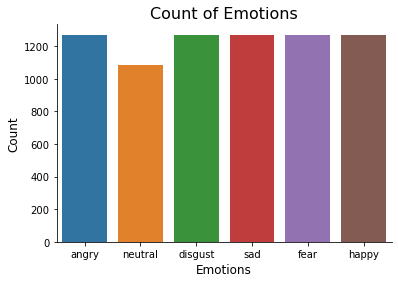

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

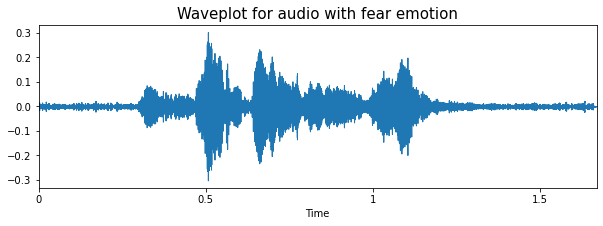

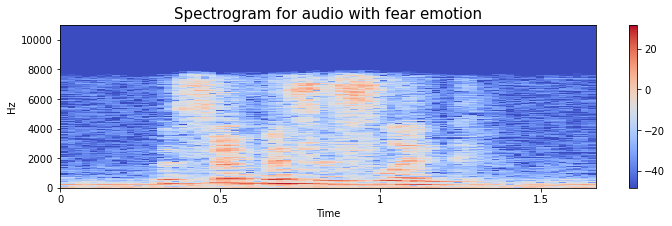

In [8]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

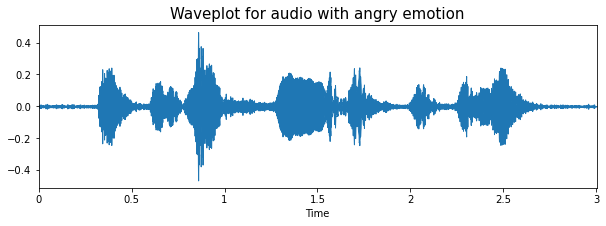

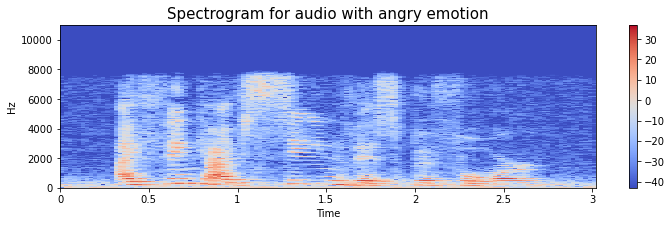

In [9]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

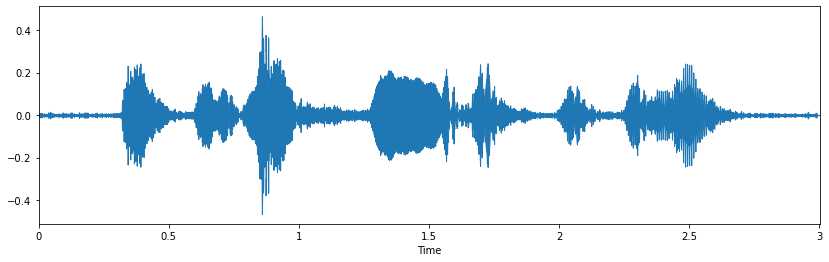

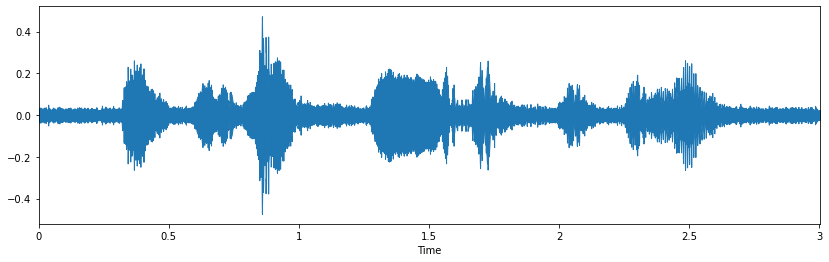

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [13]:
X, Y = [], []
n = 1;
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
        if (n%500 == 0): print (n)
        n+=1

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000


In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.099805,0.592653,0.551920,0.522892,0.471200,0.524253,0.496238,0.520657,0.578098,0.581673,...,2.148597e-06,2.065203e-06,1.991845e-06,1.925834e-06,1.868376e-06,1.821455e-06,1.783586e-06,1.756794e-06,1.739427e-06,angry
1,0.257562,0.733846,0.690768,0.665664,0.680992,0.695140,0.606972,0.671858,0.657102,0.678315,...,1.853614e-02,1.762755e-02,1.737604e-02,1.694127e-02,1.752663e-02,1.707268e-02,1.753704e-02,1.749871e-02,1.804485e-02,angry
2,0.099121,0.485392,0.601693,0.530879,0.488195,0.439506,0.515747,0.486791,0.500563,0.572407,...,2.065903e-06,1.993190e-06,1.949203e-06,1.886168e-06,1.845606e-06,1.826539e-06,1.906959e-06,2.094231e-06,2.232310e-06,angry
3,0.097346,0.592933,0.503150,0.504115,0.568304,0.524867,0.473888,0.554124,0.548831,0.503012,...,6.301072e-08,5.613409e-08,5.090190e-08,4.680120e-08,4.359725e-08,4.115187e-08,3.931180e-08,3.804773e-08,3.727246e-08,angry
4,0.261165,0.764039,0.692710,0.691052,0.747914,0.700558,0.584697,0.621712,0.637003,0.590433,...,1.759799e-02,1.727187e-02,1.666744e-02,1.692897e-02,1.657551e-02,1.792403e-02,1.635695e-02,1.694197e-02,1.548313e-02,angry


In [4]:
#Use this to read from CSV directly
Features = pd.read_csv("features.csv")

In [17]:
X = Features.iloc[: ,:-3].values
Y = Features['labels'].values

In [10]:
#only call this for CNN # As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744,), (5582, 162), (5582,))

In [19]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744,), (5582, 162), (5582,))

In [11]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744,), (5582, 162, 1), (5582,))

In [15]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score #computes F1 score
from sklearn.metrics import accuracy_score #compute accuracy
from sklearn.pipeline import Pipeline

In [20]:
pipe0 = Pipeline( [('scaler' , StandardScaler()), ('Log', LogisticRegression(penalty='l2',max_iter=10000, multi_class = "ovr"))])
pipe0.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('Log', LogisticRegression(max_iter=10000, multi_class='ovr'))])

In [21]:
pred = pipe0.predict(x_train)
pred_test = pipe0.predict(x_test)

In [22]:
print("accuracy score for Train set is:", accuracy_score(y_train, pred))
print("accuracy score for Test set is: ", accuracy_score(y_test,pred_test))

print(pipe0.classes_)
print("F1 score for Train set is:", f1_score(y_train, pred, average = None))
print("F1 score for Test set is: ", f1_score(y_test,pred_test, average = None))

accuracy score for Train set is: 0.4567606306736742
accuracy score for Test set is:  0.446434969544966
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
F1 score for Train set is: [0.6352366  0.36098774 0.31987646 0.40211042 0.4093315  0.54985398]
F1 score for Test set is:  [0.62233766 0.35443038 0.28310502 0.38913525 0.39950372 0.5572264 ]


In [23]:
#SVM 

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [24]:
pipe1 = Pipeline([('scaler', StandardScaler()), ('svc', svm.SVC())])

In [25]:
pipe1.fit(x_train,y_train)
pipe1.score(x_test,y_test)

0.48548907201719815

In [35]:
pred = pipe1.predict(x_train)
pred_test = pipe1.predict(x_test)

print("accuracy score for Train set is:", accuracy_score(y_train, pred))
print("accuracy score for Test set is: ", accuracy_score(y_test,pred_test))

print(pipe0.classes_)
print("F1 score for Train set is:", f1_score(y_train, pred, average = None))
print("F1 score for Test set is: ", f1_score(y_test,pred_test, average = None))

accuracy score for Train set is: 0.5213807931199236
accuracy score for Test set is:  0.48548907201719815
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
F1 score for Train set is: [0.71323529 0.40532493 0.44177778 0.5039315  0.459475   0.57938234]
F1 score for Test set is:  [0.66666667 0.38349007 0.35505319 0.43576017 0.43708609 0.58056156]


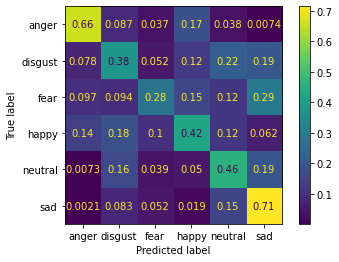

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(pred_test,axis=1))
cm = confusion_matrix(y_test, pred_test)
cm = cm/ cm.astype(np.float64).sum(axis=1)

labels = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
disp.plot()

In [27]:
pipe2 = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(dual = False))])

In [28]:
pipe2.fit(x_train,y_train)
pipe2.score(x_test,y_test)



0.43944822644213544

In [30]:
pred = pipe2.predict(x_train)
pred_test = pipe2.predict(x_test)

print("accuracy score for Train set is:", accuracy_score(y_train, pred))
print("accuracy score for Test set is: ", accuracy_score(y_test,pred_test))

print(pipe2.classes_)
print("F1 score for Train set is:", f1_score(y_train, pred, average = None))
print("F1 score for Test set is: ", f1_score(y_test,pred_test, average = None))

accuracy score for Train set is: 0.45287864309603443
accuracy score for Test set is:  0.43944822644213544
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
F1 score for Train set is: [0.63565116 0.35014164 0.27896787 0.40046074 0.40668633 0.53887606]
F1 score for Test set is:  [0.6266137  0.3372549  0.2251462  0.37987564 0.39704069 0.54412893]
